# Notebook NN Oblique Projections

En este Notebook se exploran los resultados del algoritmo de Oblique Projections aplicado en redes neuronales. El archivo en el que se encuentra la implementación de este algoritmo es `NObSP_Decomposition_eps.py`

## Importar librerías

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from torchviz import make_dot
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from NObSP_Decomposition_eps import (
    ObSP,
    NObSP_SVM_single,
    NObSP_SVM_2order,
    NObSP_NN_single,
    NObSP_NN_2order,
    NObSP_NN_single_eps,
)
from sklearn.model_selection import train_test_split
from Regression_NN_NObSP import Regression_NN_NObSP

## Definición del modelo

In [2]:
N = 1000; # Defining the number of datapoints
epochs = 500 # Definning numebr of epochs to train the models
learning_rate = 0.05 # DEfining learning rate of the model

In [3]:
# Input variables
x0 = np.random.randn(N,)/3
x1 = np.random.randn(N,)/3
x2 = np.random.randn(N,)/3
x3 = np.random.randn(N,)
x4 = np.random.randn(N,)/3

In [4]:
# Nonlinear functions definition
g0 = np.abs(x0)
g1 = x1**3
g2 = np.exp(x2)
g3 = np.sin(2*x3)
g4 = np.zeros(N,) # Notice that the contribution of x4 on the output is zero.
g01 = 1*np.exp(x0+x1) # Second order interaction effect
noise = 0.01*np.random.randn(N,) # noise vector

In [5]:
# Generating the model output
y =  g0 + g1 + g2 + g3 + g4 + noise # Simulation done using only first order interactions in the output.
y2 =  g0 + g1 + g2 + g3 + g4 + g01 + noise # Simulation done using second order interactions in the output.

In [6]:
# Generating the input matriz for training
X = np.stack((x0, x1, x2, x3, x4), axis=1)
t = np.arange(0,N)

In [7]:
## Preparing the data for the model

train_split = int(0.8*N) # 80% of the data to be used as training

X = torch.from_numpy(X).type(torch.float) # Converting the input matrix to a Pytorch tensor format 
y = torch.from_numpy(y).type(torch.float).unsqueeze(dim=-1) # Converting the output data to a Pytorch tensor format 

# Normalizing the input data
X_mean = torch.mean(X,dim=0) 
X_var = torch.var(X,dim=0)
X = (X-X_mean)/X_var

# Split of the data for training and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size = train_split,
                                                    random_state=42) 

In [8]:
class Regression_NN(nn.Module):
    def __init__(self, in_number, out_number):
        super(Regression_NN, self).__init__()
        self.Linear_1 = nn.Linear(in_features = in_number, out_features = 100)
        self.Linear_2 = nn.Linear(in_features = 100, out_features = 500)
        self.Linear_3 = nn.Linear(in_features = 500, out_features = 1000)
        self.Linear_4 = nn.Linear(in_features = 1000, out_features = 1000)
        self.Linear_5 = nn.Linear(in_features = 1000, out_features = out_number)
        
    def forward(self,x):
        x = F.relu(self.Linear_1(x))
        x = F.relu(self.Linear_2(x))
        x = F.relu(self.Linear_3(x))
        x_t = F.relu(self.Linear_4(x)) # Computing the transformation done to the vector in the layer previous to the output
        x = self.Linear_5(x_t)
        
        return x, x_t

In [9]:
## Creating model for single nonlinear effects

model_1 = Regression_NN(5,1) # Creating the model
loss_fcn = nn.MSELoss() # Definning loss function
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=learning_rate)  # Defining optimizer

# Training loop for the model 1

for epoch in range(epochs):
    model_1.train() # Setting the model in training mode
    y_p, x_p = model_1(X_train) #forward pass
    #y_p.squeeze()
    loss = loss_fcn(y_p,
                    y_train)  # Compute Loss
    loss.backward() # compute backward
    optimizer.step() # update parameters
    optimizer.zero_grad() #zero grad optimizer
    
    ## Testing
    model_1.eval() # Setting the model in evalaution mode
    with torch.inference_mode():
        y_pred, x_trans = model_1(X_test) # Estimating th emodel output in test data
    
    test_loss = loss_fcn(y_pred,
                         y_test) # Evaluating loss
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | test Loss: {test_loss:.5f}') # Printing the performance of the model as it is trained
    

model_1.eval() # Setting the model in evaluation mode
with torch.inference_mode():
    y_est_1, x_trans_total_1 = model_1(X) # Computing the nonlinear transformation of the input data X

Epoch: 0 | Loss: 2.44988 | test Loss: 0.77095
Epoch: 100 | Loss: 0.42897 | test Loss: 0.42607
Epoch: 200 | Loss: 0.39240 | test Loss: 0.40632
Epoch: 300 | Loss: 0.33377 | test Loss: 0.36797
Epoch: 400 | Loss: 0.20967 | test Loss: 0.25814


In [10]:
P_xy_1, y_e_1, Alpha_NN_1 = NObSP_NN_single(X, y_est_1, model_1) # Computing the decomposition iusing NObSP. The Alpha parameters are the weigths for the Interpretation Layer
y_e_Alpha_1 = x_trans_total_1@Alpha_NN_1 # Computing the decomposition using the Alpha coefficients, out-of-sample extension

y_e_1 = y_e_1.cpu() # Setting th eoutput variables in the cpu.

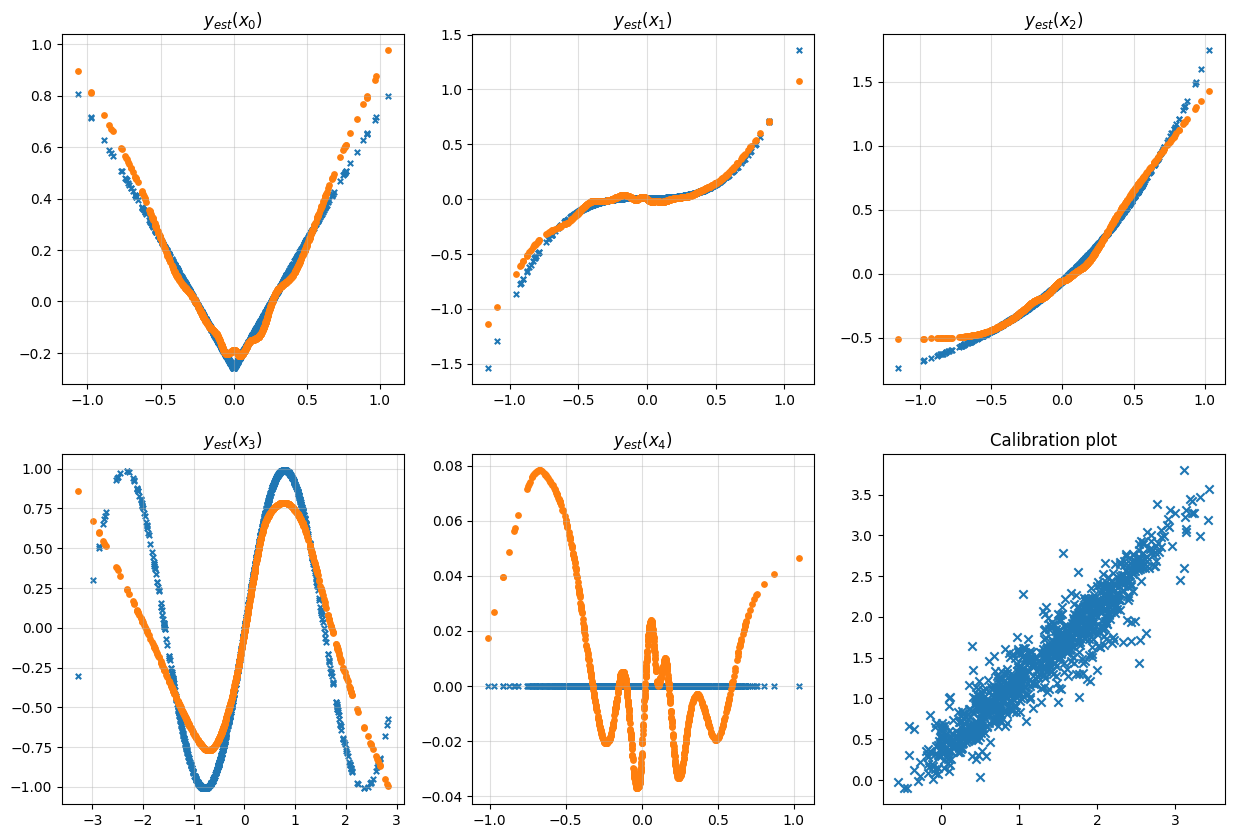

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
s = 15

for i, ax in enumerate(axs.flatten()):
    if i == 5:
        break
    x = [x0, x1, x2, x3, x4][i % 5]
    g = [g0, g1, g2, g3, g4][i % 5]
    y_e = y_e_1[:, i % 5]
    title = "$y_{{est}}(x_{})$".format(i % 5, 0 if i < 5 else 1)
    ax.scatter(x, g - g.mean(), marker="x", s=s)
    ax.scatter(x, y_e - y_e.mean(), marker="o", s=s)
    ax.set_title(title)
    ax.grid(alpha=0.4)

axs[1, 2].scatter(y.cpu(), y_est_1.cpu(), marker="x")
axs[1, 2].set_title("Calibration plot")
plt.show()

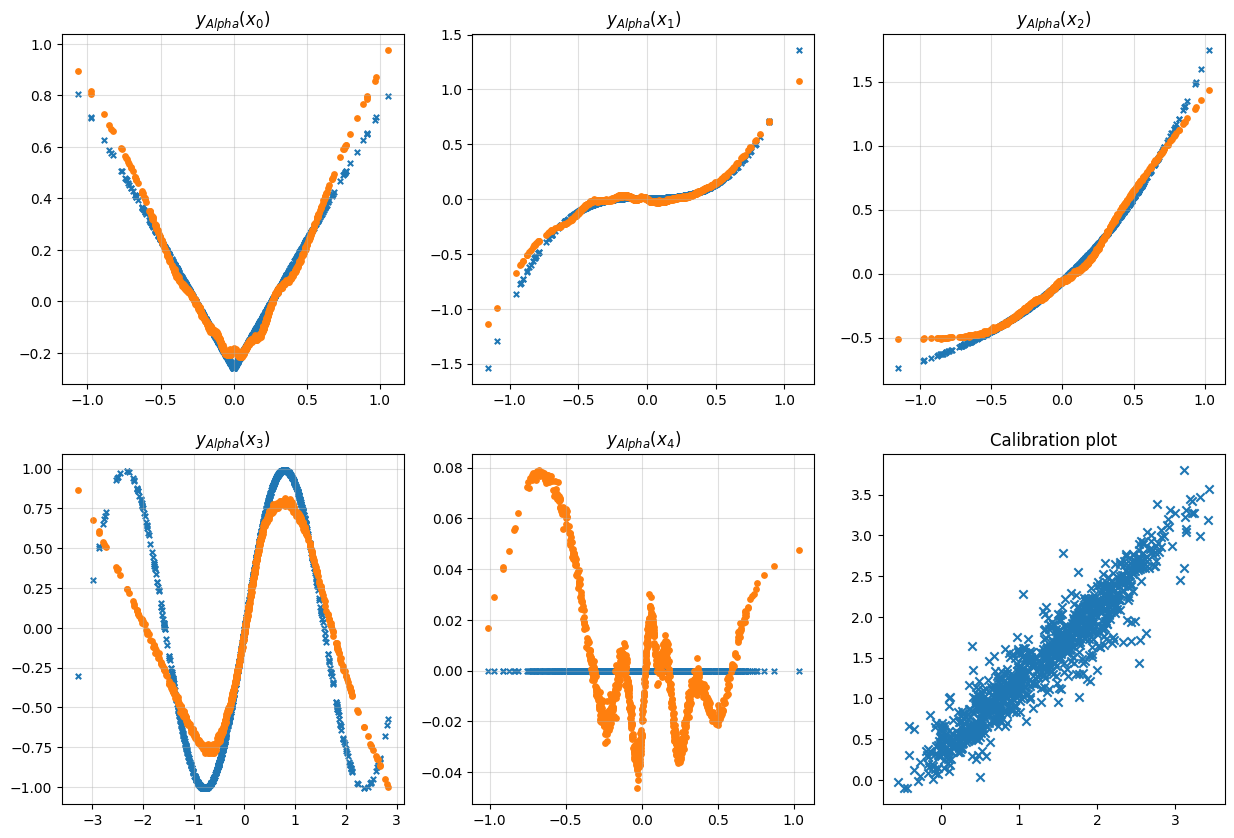

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
s = 15

for i, ax in enumerate(axs.flatten()):
    if i == 5:
        break
    x = [x0, x1, x2, x3, x4][i % 5]
    g = [g0, g1, g2, g3, g4][i % 5]
    y_e = y_e_Alpha_1[:, i % 5]
    title = "$y_{{Alpha}}(x_{})$".format(i % 5, 0 if i < 5 else 1)
    ax.scatter(x, g - g.mean(), marker="x", s=s)
    ax.scatter(x, y_e - y_e.mean(), marker="o", s=s)
    ax.set_title(title)
    ax.grid(alpha=0.4)

axs[1, 2].scatter(y.cpu(), y_est_1.cpu(), marker="x")
axs[1, 2].set_title("Calibration plot")
plt.show()

## New approach Using Epsilon

In [13]:
P_xy_1, _, y_est, y_est_eps, y_final, Alpha_NN_1 = NObSP_NN_single_eps(X, y_est_1, model_1, eps = 0.0) # Computing the decomposition iusing NObSP. The Alpha parameters are the weigths for the Interpretation Layer
y_e_Alpha_1 = x_trans_total_1@Alpha_NN_1 # Computing the decomposition using the Alpha coefficients, out-of-sample extension

y_est = y_est.cpu() # Setting the output variables in the cpu.
y_est_eps = y_est_eps.cpu()
y_final = y_final.cpu()

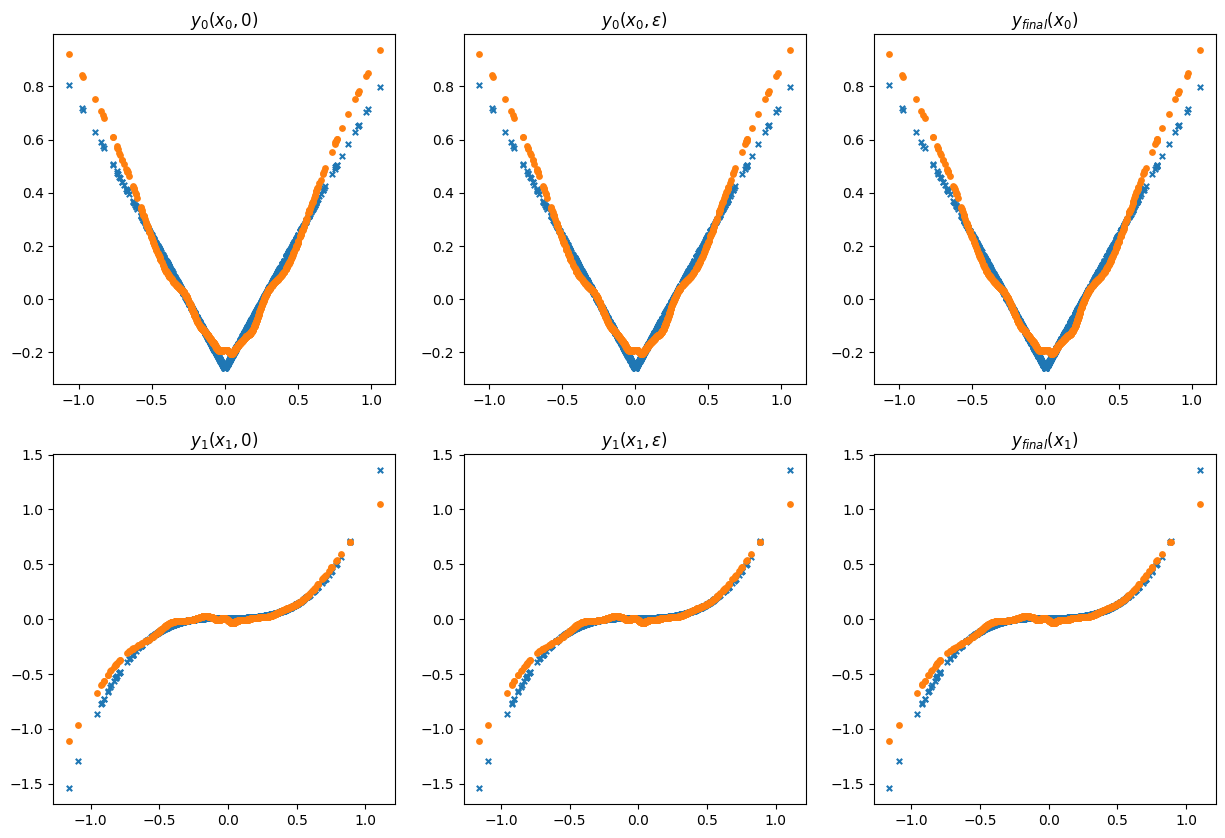

In [14]:
fig, axs = plt.subplots(2,3, figsize = (15, 10))
s = 15
axs[0,0].scatter(x0,g0-g0.mean(), marker='x', s = s) # Real nonlienar contribution of x0 on the output
axs[0,0].scatter(x0,y_est[:,0]-y_est[:,0].mean(),marker='o', s = s) # Estimated nonlinear contribution of x0 on the output
axs[0,0].set_title("$y_{0}(x_{0}, 0)$")

axs[1,0].scatter(x1,g1-g1.mean(), marker='x', s = s) # Real nonlienar contribution of x0 on the output
axs[1,0].scatter(x1,y_est[:,1]-y_est[:,1].mean(),marker='o', s = s) # Estimated nonlinear contribution of x0 on the output
axs[1,0].set_title("$y_{1}(x_{1}, 0)$")


axs[0,1].scatter(x0,g0-g0.mean(), marker='x', s = s) # Real nonlienar contribution of x0 on the output
axs[0,1].scatter(x0,y_est_eps[:,0]-y_est_eps[:,0].mean(),marker='o', s = s) # Estimated nonlinear contribution of x0 on the output
axs[0,1].set_title("$y_{0}(x_{0}, \epsilon)$")

axs[1,1].scatter(x1,g1-g1.mean(), marker='x', s = s) # Real nonlienar contribution of x0 on the output
axs[1,1].scatter(x1,y_est_eps[:,1]-y_est_eps[:,1].mean(),marker='o', s = s) # Estimated nonlinear contribution of x0 on the output
axs[1,1].set_title("$y_{1}(x_{1}, \epsilon)$")


axs[0,2].scatter(x0,g0-g0.mean(), marker='x', s = s) # Real nonlienar contribution of x0 on the output
axs[0,2].scatter(x0,y_final[:,0]-y_final[:,0].mean(),marker='o', s = s) # Estimated nonlinear contribution of x0 on the output
axs[0,2].set_title("$y_{final}(x_{0})$")

axs[1,2].scatter(x1,g1-g1.mean(), marker='x', s = s) # Real nonlienar contribution of x0 on the output
axs[1,2].scatter(x1,y_final[:,1]-y_final[:,1].mean(),marker='o', s = s) # Estimated nonlinear contribution of x0 on the output
axs[1,2].set_title("$y_{final}(x_{1})$")

plt.show()

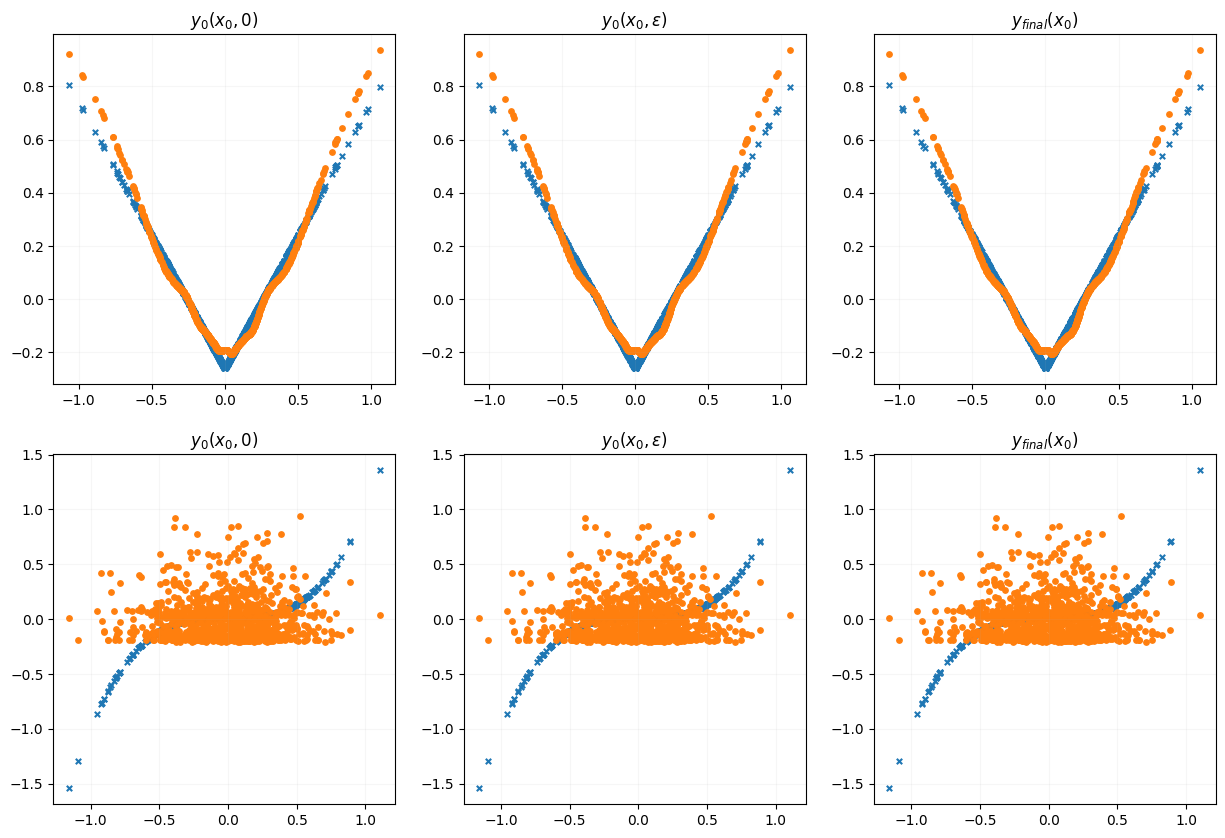

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
s = 15

for i, ax in enumerate(axs.flatten()):
    x = x0 if i < 3 else x1
    g = g0 if i < 3 else g1
    y = y_est[:, 0] if i % 3 == 0 else y_est_eps[:, 0] if i % 3 == 1 else y_final[:, 0]
    ax.scatter(x, g - g.mean(), marker='x', s=s)
    ax.scatter(x, y - y.mean(), marker='o', s=s)
    title = "$y_{{0}}(x_{{0}}, 0)$" if i % 3 == 0 else "$y_{{0}}(x_{{0}}, \\epsilon)$" if i % 3 == 1 else "$y_{{final}}(x_{{0}})$"
    ax.set_title(title.format(i % 3))
    ax.grid(alpha = 0.1)
    
plt.show()